# 0 -- set up environment

## magic commands

In [23]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger, so this command turns the debugger OFF
%pdb off

Automatic pdb calling has been turned OFF


## NumPy, SciPy, Matplotlib, SymPy

In [24]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# animation
from matplotlib import animation as ani
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym


## OS and Colab/Jupyter 

In [25]:
# os = operating system; access OS-level commands
# e.g. create directory, delete file, execute command
# (more platform-independent than "!")
import os

In [26]:
# test whether this is a Colaboratory or Jupyter notebook
try:
  import google.colab
  COLAB = True
  print('Colaboratory Notebook')
except:
  COLAB = False
  print('Jupyter Notebook')

Colaboratory Notebook


In [27]:
# Colab notebook
if COLAB:
  # pip = Python package manager; "!" means "run at system level"
  !pip install control
  !pip install JSAnimation
  
  # render SymPy equations nicely in Colaboratory Notebook
  def colab_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
  
  sym.init_printing(use_latex="mathjax",latex_printer=colab_latex_printer)

# Jupyter notebook
else:
  init_printing(use_latex='mathjax')
    

# Python's Control Systems Toolbox
import control as ctrl

# SciPy module that implements many of the routines in ctrl
from scipy import signal as sig

# render animations in the notebook
from JSAnimation.IPython_display import display_animation

## helpful functions

In [30]:
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(t,x,u) 

  input:
    f : T x X x U --> X - vector field
      T - time space (subset of real numbers)
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# 1 -- nonlinear DE

## phase portraits

This is a minimal working example for creating a planar "phase portrait" to visualize CT-DE trajectories.

Consider $\dot{x} = A x$ where $A = \left[ \begin{matrix} -1 & 0 \\ 0 & +2 \end{matrix} \right]$, which we write as $\dot{x} = f(t,x,u)$ even though $f$ doesn't actually vary with $t$ or $u$ (they don't appear in the expression for $f$) in this case.

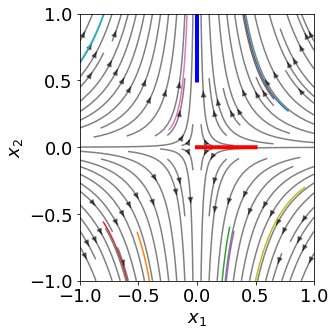

In [32]:
dt = 1e-2 # coarse timestep

A = np.array([[-1,0],
              [0,+2]])

ut = lambda t : 0

def f(t,x,u):
  dx = np.dot(A,x)
  return dx

plt.figure(figsize=(5,5))

# simulation time
t = 15

# phase portrait / "streamplot" / "quiver" plot
ax = plt.subplot(1,1,1)
X, Y = np.meshgrid(np.linspace(-1,+1, 11), np.linspace(-1, +1, 11))
dX,dY = np.asarray([f(0.,(x,y),0.).flatten() for x,y in zip(X.flatten(),Y.flatten())]).T
dX,dY = dX.reshape(X.shape),dY.reshape(Y.shape)
#ax.quiver(X,Y,dX,dY)
ax.streamplot(X,Y,dX,dY,color=(0,0,0,.5))
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

for _ in range(10):
  # random initial condition in [-1,+1] x [-1,+1] square
  x0 = 2*(np.random.rand(2) - .5)
  t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=ut)
  ax.plot(x_[:,0],x_[:,1])

# initial condition along x-axis
t_,x_ = numerical_simulation(f,t,[.5,0],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'r',lw=4)

# initial condition along y-axis
t_,x_ = numerical_simulation(f,t,[0,.5],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'b',lw=4)

ax.set_xlim((-1,+1))
ax.set_ylim((-1,+1))

plt.tight_layout()

## cruise control (nonlinear)

Force balance on car chassis yields

$$ m \dot{v} = F - F_d $$

where:
* $m$ is mass of car, passengers, and load;
* $v$ is velocity / speed of car;
* $F$ is engine force, which is proportional to control signal $0 \le u \le 1$ that specifies throttle position (that, in turn, specifies fuel injection rate), and varies nonlinearly with engine (angular) speed $\omega$,

* * $ F = \frac{R u}{r} T(\omega),\ \omega = \frac{R}{r} v, $

* * $ T(\omega) = T_m \cdot \left( 1 - \beta \cdot \left( \frac{\omega}{\omega_m} - 1 \right)^2 \right), $

* * $T_m$ is the maximum engine torque (supplied at speed $\omega_m$), $R$ is the gear ratio, and $r$ is the wheel radius;

* $F_d = F_g + F_r + F_a$ is disturbance force where:
* * $F_g = m g \sin\theta$ is the fraction of gravitational acceleration $g$ converted to gravitational force when the road has slope $\theta$;
* * $F_r = m g C_r \frac{v}{|v|}$ is the rolling / road frictional force with coefficient of friction $C_r$;
* * $F_a = \frac{1}{2} \rho C_d A |v| v$ is the aerodynamic drag force from air density $\rho$, frontal car area $A$, and (shape-dependent) coefficient of aerodynamic drag $C_d$.

Taken together, we have a nonlinear differential equation that relates control input $u$ to the rate of change in car velocity $v$:

$$ m \dot{v} = \frac{R}{r} u T\left(\frac{R}{r} v \right) - m g \sin\theta - m g C_r \frac{v}{|v|} - \frac{1}{2} \rho C_d A |v| v. $$

In [ ]:
# 2011 Ford Focus SE
m = 1500. # kg
# parameter values from [AMv2 Ch 4.1]
alpha_n = 40
r = 0.5 # m 
R = alpha_n * r
T_m = 190 # Nm
beta = 0.4
omega_m = 420 # rad/sec ~= 4000 RPM
g = 9.8 # m / sec^2
C_r = 0.01
rho = 1.3 # kg / m^3
C_d = 0.32
A = 2.4 # m^2

# proportional-integral controller parameters
k_P = 0.5
k_I = 1.

# reference velocity -- can vary over time
v_r = lambda t : 20. * np.ones_like(t) # m / sec

# road slope increases by 4 deg at time 5 sec
theta = lambda t : 4 * (np.pi/180) * (t >= 5.) # rad

# road slope increases by 4 deg at time 5 sec, then goes back to zero at 20 sec
theta = (lambda t : 4 * (np.pi/180) * (t >= 5.) * (t <= 20.)) # rad

In [ ]:
# engine torque depends on engine (rotational) velocity
def T(omega):
  return T_m * (1 - beta * (omega / omega_m - 1.)**2)

# differential equation satisfied by car velocity:  \dot{v} = f(v,u)
def dv(t,v,u): 
  return (1./m) * ((R/r) * u * T((R/r) * v)         # F
                   - m * g * np.sin(theta(t))       # F_g
                   - m * g * C_r * v / np.abs(v)    # F_r
                   - (1./2) * rho * C_d * A * v**2) # F_a

# differential equation satisfied by proportional-integral controller state
def dz(t,v):
  return v_r(t) - v

# proportional-integral controller
def u(t,v,z):
  return k_P * (v_r(t) - v) + k_I * z

In [ ]:
# initialize at reference velocity
v0 = v_r(0.) # m / sec

# integrator state that makes v0 an equilibrium
u0 = op.root(lambda u : dv(0.,v0,u),0.)['x'][0]
z0 = u0 / k_I

# controlled system state consists of car velocity and error integral
x0 = np.asarray([v0,z0])

def f(t,x):
  v,z = x
  return np.asarray([dv(t,v,u(t,v,z)),dz(t,v)])

print('x0 an equilibrium? ',np.allclose(f(0.,x0),0.))

('x0 an equilibrium? ', True)


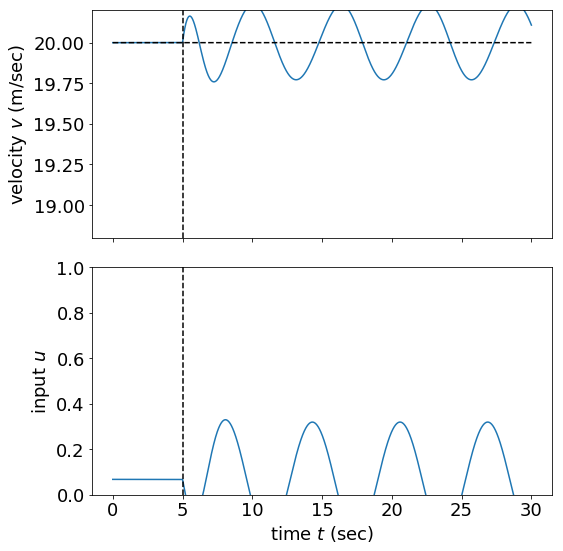

In [ ]:
t = 30. # sec; simulation duration

t_,x_ = numerical_simulation(f,t,x0)

v_,z_ = x_.T

plt.figure(figsize=(8,8))

ax = plt.subplot(2,1,1)
ylim = (18.8,20.2)
ax.plot(t_,v_)
ax.plot(5.*np.ones(2),ylim,'k--')
ax.plot(t_,v_r(t_),'k--')
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_ylabel(r'velocity $v$ (m/sec)')


ax = plt.subplot(2,1,2)
ylim = (0.,1.)
ax.plot(t_,u(t_,v_,z_))
ax.plot(5.*np.ones(2),ylim,'k--')
ax.set_ylim(ylim)
ax.set_ylabel(r'input $u$')

ax.set_xlabel(r'time $t$ (sec)'); # semicolon suppresses text printout

plt.tight_layout()

## predator/prey

Letting
$L(t)$ 
denote number of lynxes (predators)
and
$H(t)$ 
denote number of hares (prey),
the population dynamics are
$$\dot{H} = r H \left( 1 - \frac{H}{k} \right) - \frac{a H L}{c + H},\ H \ge 0,$$
$$\dot{L} = b \frac{a H L}{c + H} - d L,\ L \ge 0,$$
where:
* $r$ is growth rate of hares,
* $k$ is maximum hare population (in absence of lynxes),
* $a$ is consumption rate of hares as lynx population increases,
* $c$ limits prey consumption rate at low population,
* $b$ is grown coefficient of lynxes,
* $d$ is mortality rate of lynxes.

In [14]:
# use symbolic algebra to find equilibria
r,k,a,c,b,d = sym.symbols(r'r,k,a,c,b,d')
t,H,L = sym.symbols(r't,H,L')

dH = r * H * (1 - H / k) - a * H * L / (c + H)
dL = b * a * H * L / (c + H) - d * L

eqs = [dict(zip([H,L],eq)) for eq in sym.simplify(sym.solve([dH,dL],[H,L]))]
print(eqs)

[{H: 0, L: 0}, {H: k, L: 0}, {H: c*d/(a*b - d), L: -b*c*r*(-a*b*k + c*d + d*k)/(k*(a*b - d)**2)}]


We find three equilibria:
$$(H^*,L^*) = (0,0),\ (H^*,L^*) = (k,0),$$
$$(H^*,L^*) = \left(\frac{c d}{a b - d}, \frac{b c r (a b k - c d - d k)}{k (a b - d)^2}\right)$$
The first two correspond to the uninteresting / ecologically undesirable situation where there are no predators (and possibly no prey), so we'll focus on the third.

In [15]:
eq = eqs[2]

p = {a:3.2, b:0.6, c:50, d:0.56, k:125, r:1.6}

x = (H,L)
dx = sym.Matrix([dH,dL])

f = sym.lambdify((t,x),dx.subs(p))

(-5.0096578366445925, 100.0)

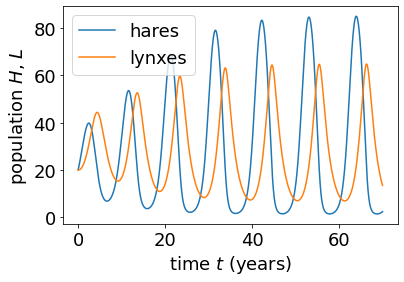

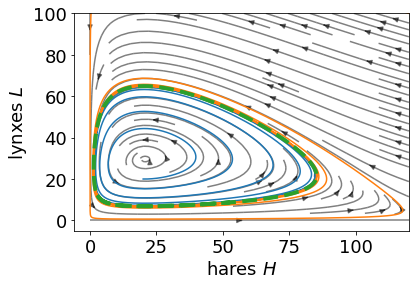

In [19]:
t = 70. # sec; simulation duration

x0 = np.asarray([20,20])

t_,x_ = numerical_simulation(lambda t,x : f(t,x).flatten(),t,x0,dt=1e-2)

H_,L_ = x_.T

# time trajectory
plt.figure()

ax = plt.subplot(1,1,1)
ax.plot(t_,H_,label='hares')
ax.plot(t_,L_,label='lynxes')
ax.legend()
ax.set_ylabel(r'population $H$, $L$')
ax.set_xlabel(r'time $t$ (years)')


# phase portrait / "quiver" plot
plt.figure()

H, L = np.meshgrid(np.linspace(0, 120, 12), np.linspace(0, 100, 10))
dH,dL = np.asarray([f(0.,(h,l)).flatten() for h,l in zip(H.flatten(),L.flatten())]).T
dH,dL = dH.reshape(H.shape),dL.reshape(L.shape)

ax = plt.subplot(1,1,1)
ax.plot(H_,L_)
#ax.quiver(H,L,dH,dL)
ax.streamplot(H,L,dH,dL,color=(0,0,0,.5))
ax.set_xlabel(r'hares $H$')
ax.set_ylabel(r'lynxes $L$')
ylim = ax.get_ylim()

x0 = np.asarray([120,100])
t_,x_ = numerical_simulation(lambda t,x : f(t,x).flatten(),t,x0,dt=1e-2)
H_,L_ = x_.T
ax.plot(H_,L_)
ax.plot(H_[-t_.size//5:],L_[-t_.size//5:],'--',lw=4)
ax.set_ylim(ylim)


# 2 -- linear DE

## cruise control (linear)

Consider the (negative) feedback block diagram:

![feedback block diagram](http://faculty.uw.edu/sburden/447/447-hw1-feedback.png)

We can derive the transfer function that relates output $y$ to external inputs $v$ and $r$ using ***block diagram algebra*** as follows:

$$
y 
= P(v + u)
= P(v + C(r-y))
= P v + PC r - PC y
$$

$$
\iff
(1+PC) y = P v + PC r
\iff 
y = \frac{P}{1 + PC} v + \frac{PC}{1 + PC} r.
$$

Consider the first-order process model

$$ P(s) = \frac{b}{s + a} $$

that corresponds to the differential equation

$$ \dot{y} + a y = b u $$

and suppose $a, b > 0$.

This model arises in many physical systems -- velocity or angular velocity of a mechanical system; temperature of a material; liquid flowing in and out of a reservoir.

For concreteness, let's consider $P$ as a model for the velocity of a car:
* $y$ -- car velocity;
* $u$ -- throttle (gas pedal);
* $b$ -- unit conversion from force to acceleration;
* $a$ -- air resistance, wheel friction, etc;
* $r$ -- desired velocity;
* $v$ -- road slope, headwind, etc.


Let's start by applying proportional control, $C(s) = k_P$.

In [ ]:
# note:  this command creates Python variables s, a, b, k_P
# and specifies that s can be any complex number but a, b, k_P are positive real
sym.var('s',complex=True) # equivalent to s = sym.symbols('s')
sym.var('a,b,k_P',positive=True)

P = b / (s + a)
C = k_P

G_yv = P / (1 + P * C)

# un-simplified
print('unsimplified G_yv =',G_yv)

# simplified
G_yv = sym.simplify(G_yv)
print('simplified G_yv =',G_yv)

# formatted 
G_yv

unsimplified G_yv = b/((a + s)*(b*k_P/(a + s) + 1))
simplified G_yv = b/(a + b*k_P + s)


      b      
─────────────
a + b⋅k_P + s

In [ ]:
# SymPy can tell me the LaTeX code corresponding to an expression
print(sym.latex(G_yv))

\frac{b}{a + b k_{P} + s}


In [ ]:
# numerator and denominator of rational function G_yv
# den is the characteristic polynomial of G_yv
num,den = sym.fraction(G_yv)

roots = sym.solve(den, s)

print('roots of characteristic polynomial s =',roots)

roots of characteristic polynomial s = [-a - b*k_P]


In [ ]:
# since we specified a, b, k_P > 0, SymPy knows the root is negative
roots[0].is_negative

True

In [ ]:
# static gain (AKA DC gain) G_yv(0)
G_yv.subs(s,0) # equivalently: G_yv.subs({s:0})

    b    
─────────
a + b⋅k_P

For any $k_P > 0$, the root $s = -a - b k_P < 0$ so the system is stable and the static gain satisfies

$$ 0 < = \frac{b}{a + b k_P} < \frac{b}{a + b \cdot 0} = \frac{b}{a}, $$

which means that the ***proportional controller*** $C(s) = k_P$ attenuates the steady-state error caused by a constant disturbance.

In [ ]:
sym.var('k_I')

C = k_P + k_I/s

G_yv = P / (1 + P * C)

G_yv = sym.simplify(G_yv)

G_yv

            b⋅s            
───────────────────────────
b⋅(k_I + k_P⋅s) + s⋅(a + s)

In [ ]:
num,den = sym.fraction(G_yv)

print('roots of characteristic polynomial s =')
sym.solve(den, s)

roots of characteristic polynomial s =


⎡                 ____________________________________                   _____
⎢                ╱  2                2    2                             ╱  2  
⎢  a   b⋅k_P   ╲╱  a  + 2⋅a⋅b⋅k_P + b ⋅k_P  - 4⋅b⋅k_I     a   b⋅k_P   ╲╱  a  +
⎢- ─ - ───── - ───────────────────────────────────────, - ─ - ───── + ────────
⎣  2     2                        2                       2     2             

_______________________________⎤
              2    2           ⎥
 2⋅a⋅b⋅k_P + b ⋅k_P  - 4⋅b⋅k_I ⎥
───────────────────────────────⎥
           2                   ⎦

In [ ]:
# static gain (AKA DC gain)
G_yv.subs(s,0) # equivalently: G_yv.subs({s:0})

0

Since the static gain is zero, the ***proportional-integral*** controller $C(s) = k_P + k_I / s$ zeros the steady-state error caused by a constant disturbance.

In [ ]:
# process model parameters
a = 1.
b = 1.

# proportional-integral controller parameters
k_P = 5
k_I = 5.

# reference velocity -- can vary over time
r = lambda t : 60. * np.ones_like(t) # miles per hour

# road slope increases at time 5 sec, causing a negative force
# then goes back to zero at 20 sec
v = (lambda t : -10 * (t >= 5.) * (t <= 20.)) # rad

In [ ]:
# differential equation satisfied by car velocity:  \dot{y} = -a y + b (u + v)
def dy(t,y,u): 
  return -a * y + b * (u + v(t))

# differential equation satisfied by proportional-integral controller state
def dz(t,y):
  return r(t) - y

# proportional-integral controller
def u(t,y,z):
  return k_P * (r(t) - y) + k_I * z

# initialize at reference velocity
y0 = r(0.) 

# initialize integrator state to zero
z0 = 0.

# controlled system state consists of car velocity and error integral
x0 = np.asarray([y0,z0])

def f(t,x):
  y,z = x
  return np.asarray([dy(t,y,u(t,y,z)),dz(t,y)])

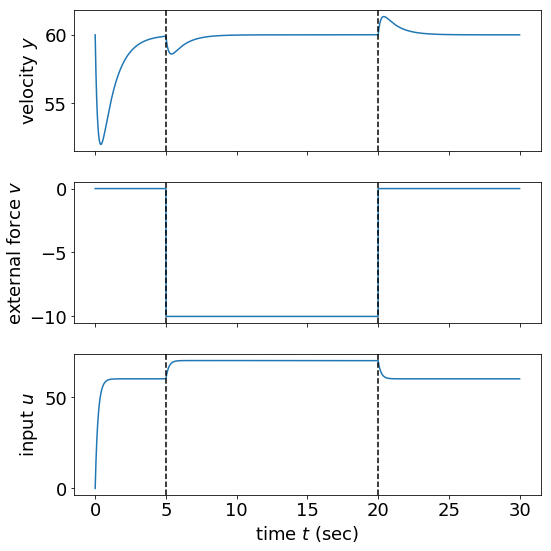

In [ ]:
t = 30. # sec; simulation duration

t_,x_ = numerical_simulation(f,t,x0)

y_,z_ = x_.T

plt.figure(figsize=(8,8))

ax = plt.subplot(3,1,1)
ax.plot(t_,y_)
ylim = ax.get_ylim()
for _ in [5., 20.]:
  ax.plot(_*np.ones(2),ylim,'k--')
ax.plot(t_,v_r(t_),'k--')
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_ylabel(r'velocity $y$')

ax = plt.subplot(3,1,2)
ax.plot(t_,v(t_))
ylim = ax.get_ylim()
for _ in [5., 20.]:
  ax.plot(_*np.ones(2),ylim,'k--')
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_ylabel(r'external force $v$')

ax = plt.subplot(3,1,3)
ax.plot(t_,u(t_,y_,z_))
ylim = ax.get_ylim()
for _ in [5., 20.]:
  ax.plot(_*np.ones(2),ylim,'k--')
ax.set_ylim(ylim)
ax.set_ylabel(r'input $u$')

ax.set_xlabel(r'time $t$ (sec)')

plt.tight_layout(); # semicolon suppresses text printout

## RLC circuit

Consider the following differential equation (DE) model of a series RLC circuit
$$ L \ddot{q} + R \dot{q} + q/C = u $$
where $q$ denotes the charge on the capacitor,
($R$, $L$, $C$) denote the (resistor, inductor, capacitor) parameters,
and $u$ denotes a series voltage source.

Letting $x = (q,\dot{q})\in\mathbb{R}^2$ denote the state of the circuit, we can rewrite (DE) in state-space form as $\dot{x} = f(x,u)$ where

$$\dot{x} = \frac{d}{dt}\left[\begin{array}{c} q \\ \dot{q} \end{array}\right] = \left[\begin{array}{c} \dot{q} \\ (-R\dot{q} - q/C + u)/L \end{array}\right] = f((q,\dot{q}),u) = f(x,u).$$

To simulate the circuit, we first implement a Python version of the state-space model; it'll be computationally expedient if $f$ accepts $t$, $x$, and $u$ as arguments even though mathematically it doesn't vary with $t$:

In [7]:
R,L,C = 1.,1.,1. # Ohm, Henry, Farad

def f(t,x,u):
    q,dq = x[0],x[1] # charge, current
    return np.hstack([dq,(-R*dq - q/C + u)/L])

Let's simulate the result of applying a sinusoidal voltage input and plot the result:

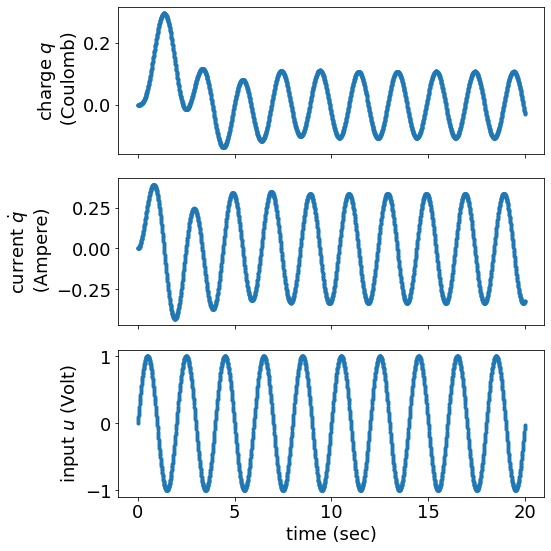

In [8]:
dt = 1e-2 # coarse timestep
freq = .5 # one cycle every two seconds
t = 10/freq # ten periods
x0 = np.hstack((0.,0.)) # no initial charge or current

# input is a periodic function of time
ut = lambda t : np.sin(2*np.pi*t*freq)
# lambda is a shorthand way to define a function
# -- equivalently:
def ut(t):
    return np.sin(2*np.pi*t*freq)

t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=ut)
u_ = np.array([ut(t) for t in t_])
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. charge and current) at time t_[j]

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,x_[:,0],'.-')
ax.set_xticklabels([])
ax.set_ylabel(r'charge $q$'+'\n (Coulomb)')

ax = plt.subplot(312)
ax.plot(t_,x_[:,1],'.-')
ax.set_xticklabels([])
ax.set_ylabel(r'current $\dot{q}$'+'\n (Ampere)')

ax = plt.subplot(313)
ax.plot(t_,u_,'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('input $u$ (Volt)')

plt.tight_layout()

So applying a sinusoidal input yielded sinusoidal fluctuations in charge and current -- this is unsurprising, since we know the circuit is actually linear.

Let's look at the linear frequency-domain model, i.e. the transfer function, which we can easily determine from the circuit's differential equation (DE) as
$$ G(s) = \frac{1}{L s^2 + R s + 1/C}. $$
To visualize how the circuit transforms signals in the frequency domain, we can create the ***Bode plot***, that is, we can plot the magnitude $|G(j\omega)|$ and angle $\angle G(j\omega)$ versus frequency $\omega$; these two plots directly tell us how a sinusoidal input at frequency $\omega$ is scaled and phase-shifted by the circuit.

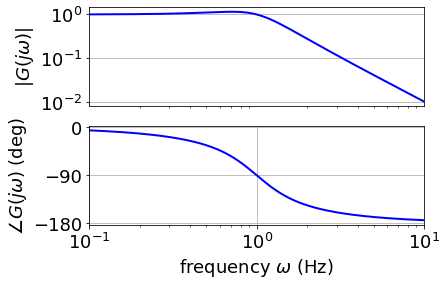

In [9]:
G = lambda s : 1. / (L*s**2 + R*s + 1/C)

omega = np.logspace(-1,1,1000)
xlim = omega[[0,-1]]

abs_G = np.abs(G(1.j*omega))
angle_G = np.unwrap(np.angle(G(1.j*omega)))*180./np.pi

plt.figure(); axs = []
ax = plt.subplot(2,1,1); ax.grid(True)
ax.loglog(omega,abs_G,'b-',lw=2)
ax.set_ylabel(r'$|G(j\omega)|$')
ax.set_yticks([10**-2,10**-1,10**0])
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid(True)
ax.semilogx(omega,angle_G,'b-',lw=2)
ax.set_xlabel(r'frequency $\omega$ (Hz)')
ax.set_ylabel(r'$\angle G(j\omega)$ (deg)')
ax.set_yticks([0,-90,-180])
ax.set_xlim(xlim)
axs.append(ax)

Now let's visualize trajectories in the ***phase space***, that is, the $(q,\dot{q})$ plane.  We'll include a plot of one trajectory versus time since that's the way we're accustomed to looking at them, and we'll highlight that trajectory (in blue) on the ***phase portrait***.

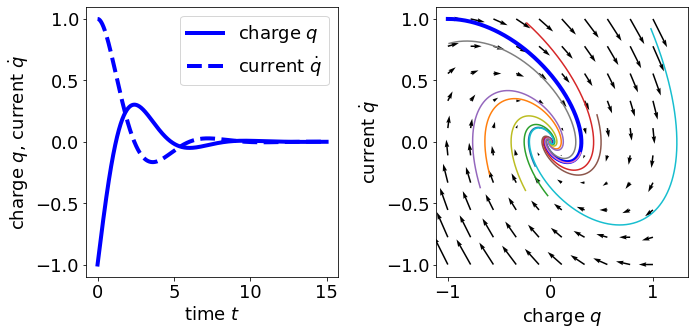

In [10]:
plt.figure(figsize=(10,5))

# initial condition
q0,dq0 = (-1.,1.)
x0 = np.array([q0,dq0])

# simulation time
t = 15

t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=lambda t : 0)
q_,dq_ = x_[:,0],x_[:,1]

# state vs time
ax = plt.subplot(1,2,1)
ax.set_xlabel(r'time $t$')
ax.set_ylabel(r'charge $q$, current $\dot{q}$')
plt.plot(t_,q_,'b',lw=4,label='charge $q$')
plt.plot(t_,dq_,'b--',lw=4,label='current $\dot{q}$')
plt.legend()

# phase portrait / "quiver" plot
ax = plt.subplot(1,2,2)
Q, Qd = np.meshgrid(np.linspace(-1,+1, 10), np.linspace(-1, +1, 10))
dQ,dQd = np.asarray([f(0.,(q,dq),0.).flatten() for q,dq in zip(Q.flatten(),Qd.flatten())]).T
dQ,dQd = dQ.reshape(dQ.shape),dQd.reshape(Qd.shape)
ax.quiver(Q,Qd,dQ,dQd)
ax.set_xlabel(r'charge $q$')
ax.set_ylabel(r'current $\dot{q}$')
ax.plot(q_,dq_,'b',lw=4)

for _ in range(10):
  # random initial condition in [-1,+1] x [-1,+1] square
  x0 = 2*(np.random.rand(2) - .5)
  t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=lambda t : 0)
  q_,dq_ = x_[:,0],x_[:,1]
  ax.plot(q_,dq_)
  

plt.tight_layout()

If we want a linear state-space model, it would be straightforward to analytically determine $A$ and $B$ such that $f(x,u) = A x + B u$ from the above equation, but if we only need a numerical answer we can let the computer determine them for us.

In [13]:
A = Jacobian(lambda x : f(0.,x,0.),x0)
B = Jacobian(lambda u : f(0.,x0,u),[0.])
B.shape = (2,1)

x = np.random.randn(2,1)
u = np.random.randn(1)

# these two ways of evaluating f do not yield exactly the same floats
# so this simple comparison will return False
# f(0.,x,u) == (A @ x + B * u).flatten()

print('f(x,u) differs from A x + B u by %0.2e'%
      np.max(np.abs(f(0.,x,u) - (A @ x + B * u).flatten())))

# instead, we use NumPy's "allclose" function, which tolerates small errors
assert np.allclose(f(0.,x,u), (A @ x + B * u).flatten())

f(x,u) differs from A x + B u by 1.13e-13
